# Etiquetage en composantes connexes

In [4]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


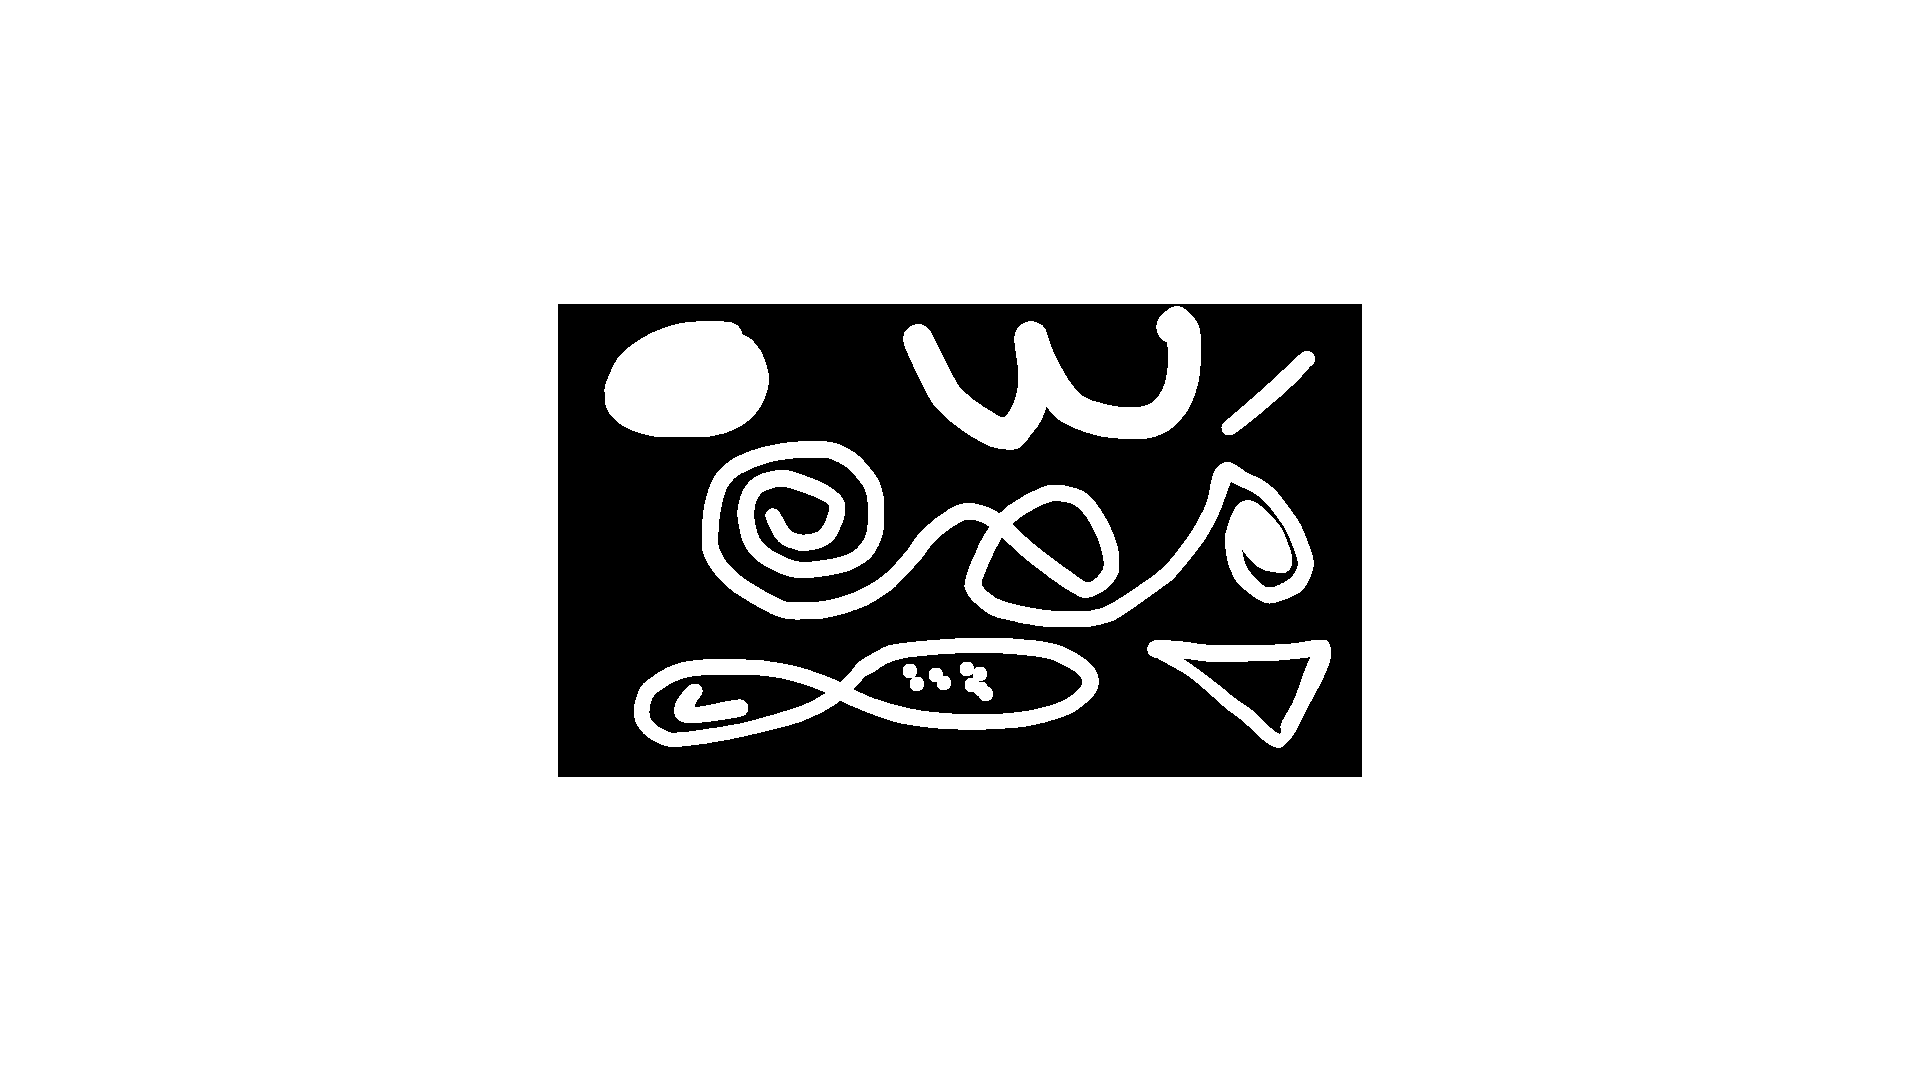

Nombre de composants connectés : 11


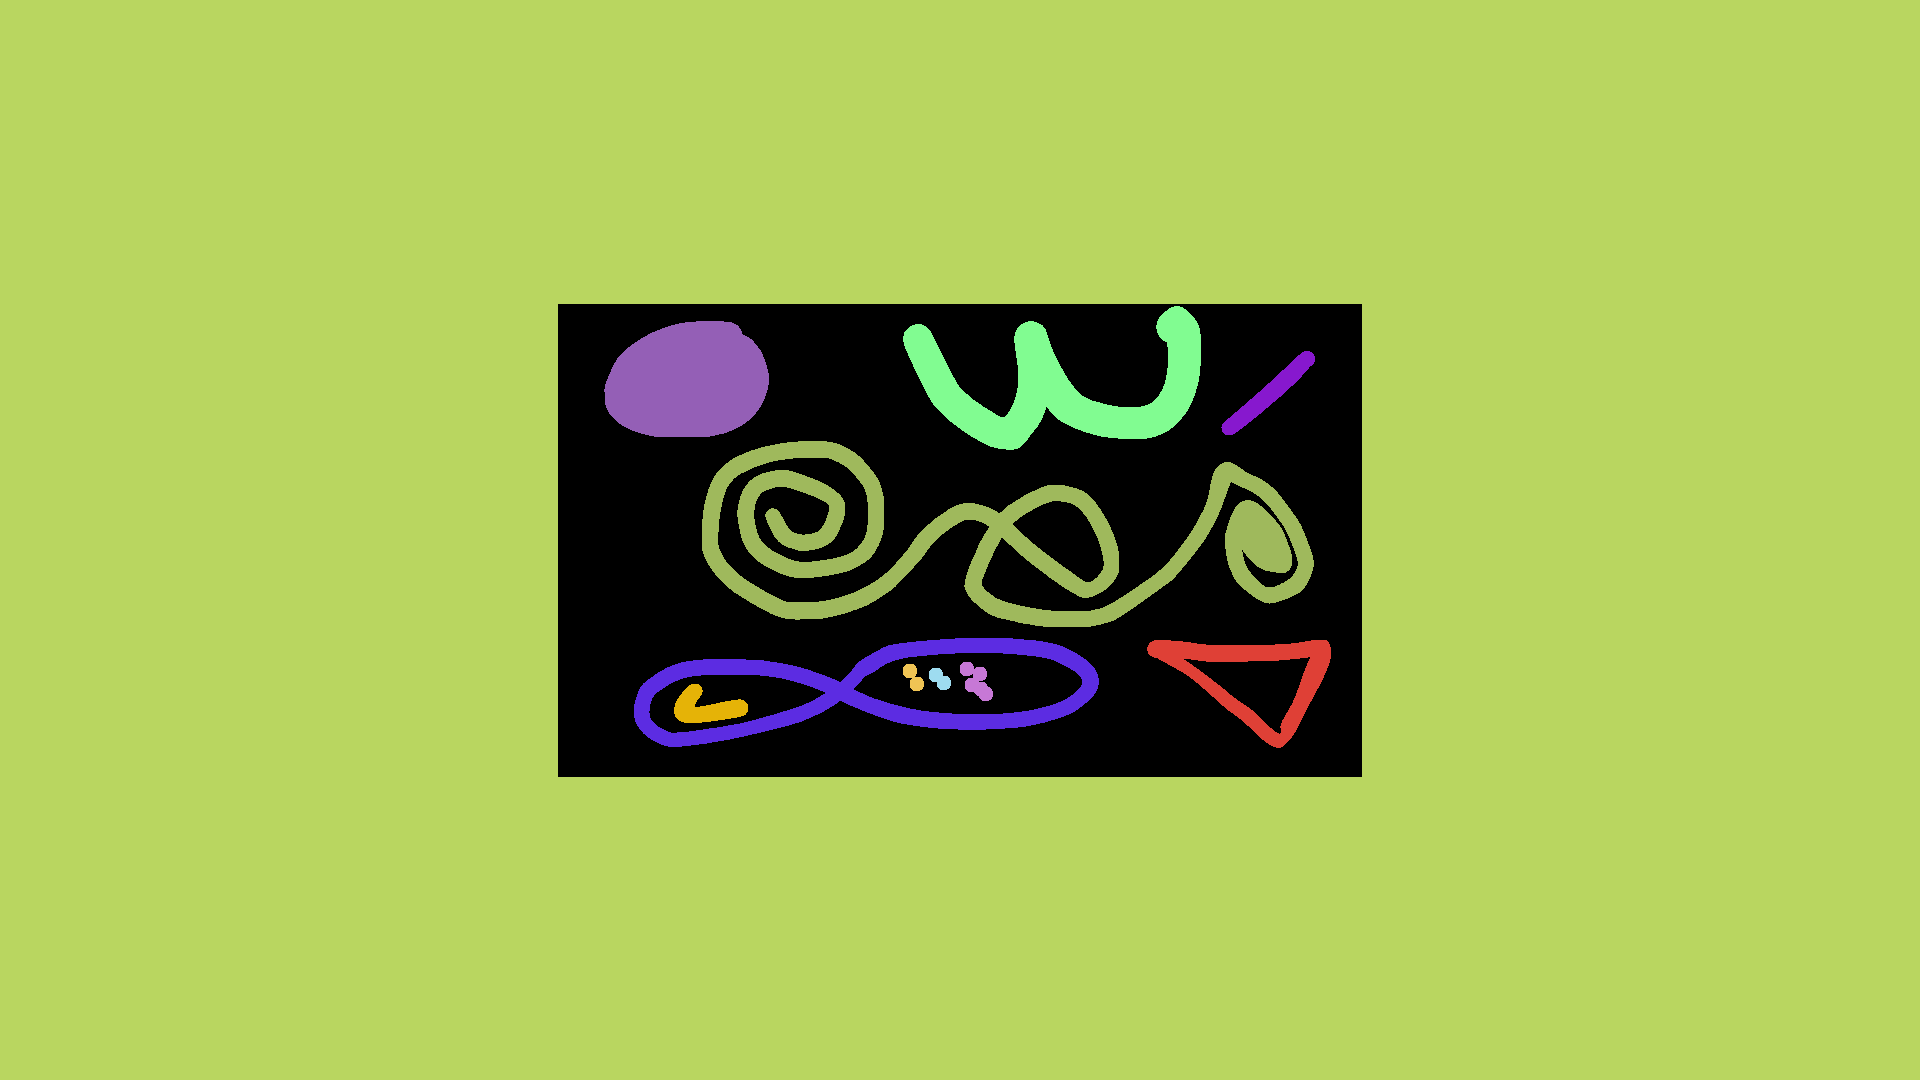

In [1]:
def binarize_image(image, threshold=127):
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def ccLabel(image):
    hauteur, largeur = image.shape
    labels = np.zeros((hauteur, largeur), dtype=int)
    label = 0

    def parcoursCC(im, p, current_label):
        stack = [p]
        component = []
        while stack:
            r = stack.pop()
            x, y = r
            if labels[x, y] == 0 and im[x, y] != 0:
                labels[x, y] = current_label
                component.append((x, y))
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < hauteur and 0 <= ny < largeur and labels[nx, ny] == 0:
                        stack.append((nx, ny))
        return component

    components = {}
    for i in range(hauteur):
        for j in range(largeur):
            if image[i, j] != 0 and labels[i, j] == 0:
                label += 1
                components[label] = parcoursCC(image, (i, j), label)

    return labels, components

def colorize_components(labels):
    unique_labels = np.unique(labels)
    color_map = {label: np.random.randint(0, 255, 3) for label in unique_labels if label != 0}
    color_image = np.zeros((*labels.shape, 3), dtype=np.uint8)

    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i, j] in color_map:
                color_image[i, j] = color_map[labels[i, j]]

    return color_image

def ccAreaFilter(image, threshold):
    labels, components = ccLabel(image)
    filtered_image = np.zeros_like(image)

    for label, pixels in components.items():
        if len(pixels) >= threshold:
            for x, y in pixels:
                filtered_image[x, y] = image[x, y]

    return filtered_image

def main():
    # Charger une image en niveaux de gris pour ccLabel
    image_gray = cv2.imread('/content/Untitled design.png', cv2.IMREAD_GRAYSCALE)
    binary_image = binarize_image(image_gray)
    cv2_imshow(binary_image)
    labels, components = ccLabel(binary_image)
    print("Nombre de composants connectés :", len(components))

    colored_image = colorize_components(labels)
    cv2_imshow(colored_image)

if __name__ == "__main__":
    main()


# Filtre d'aire

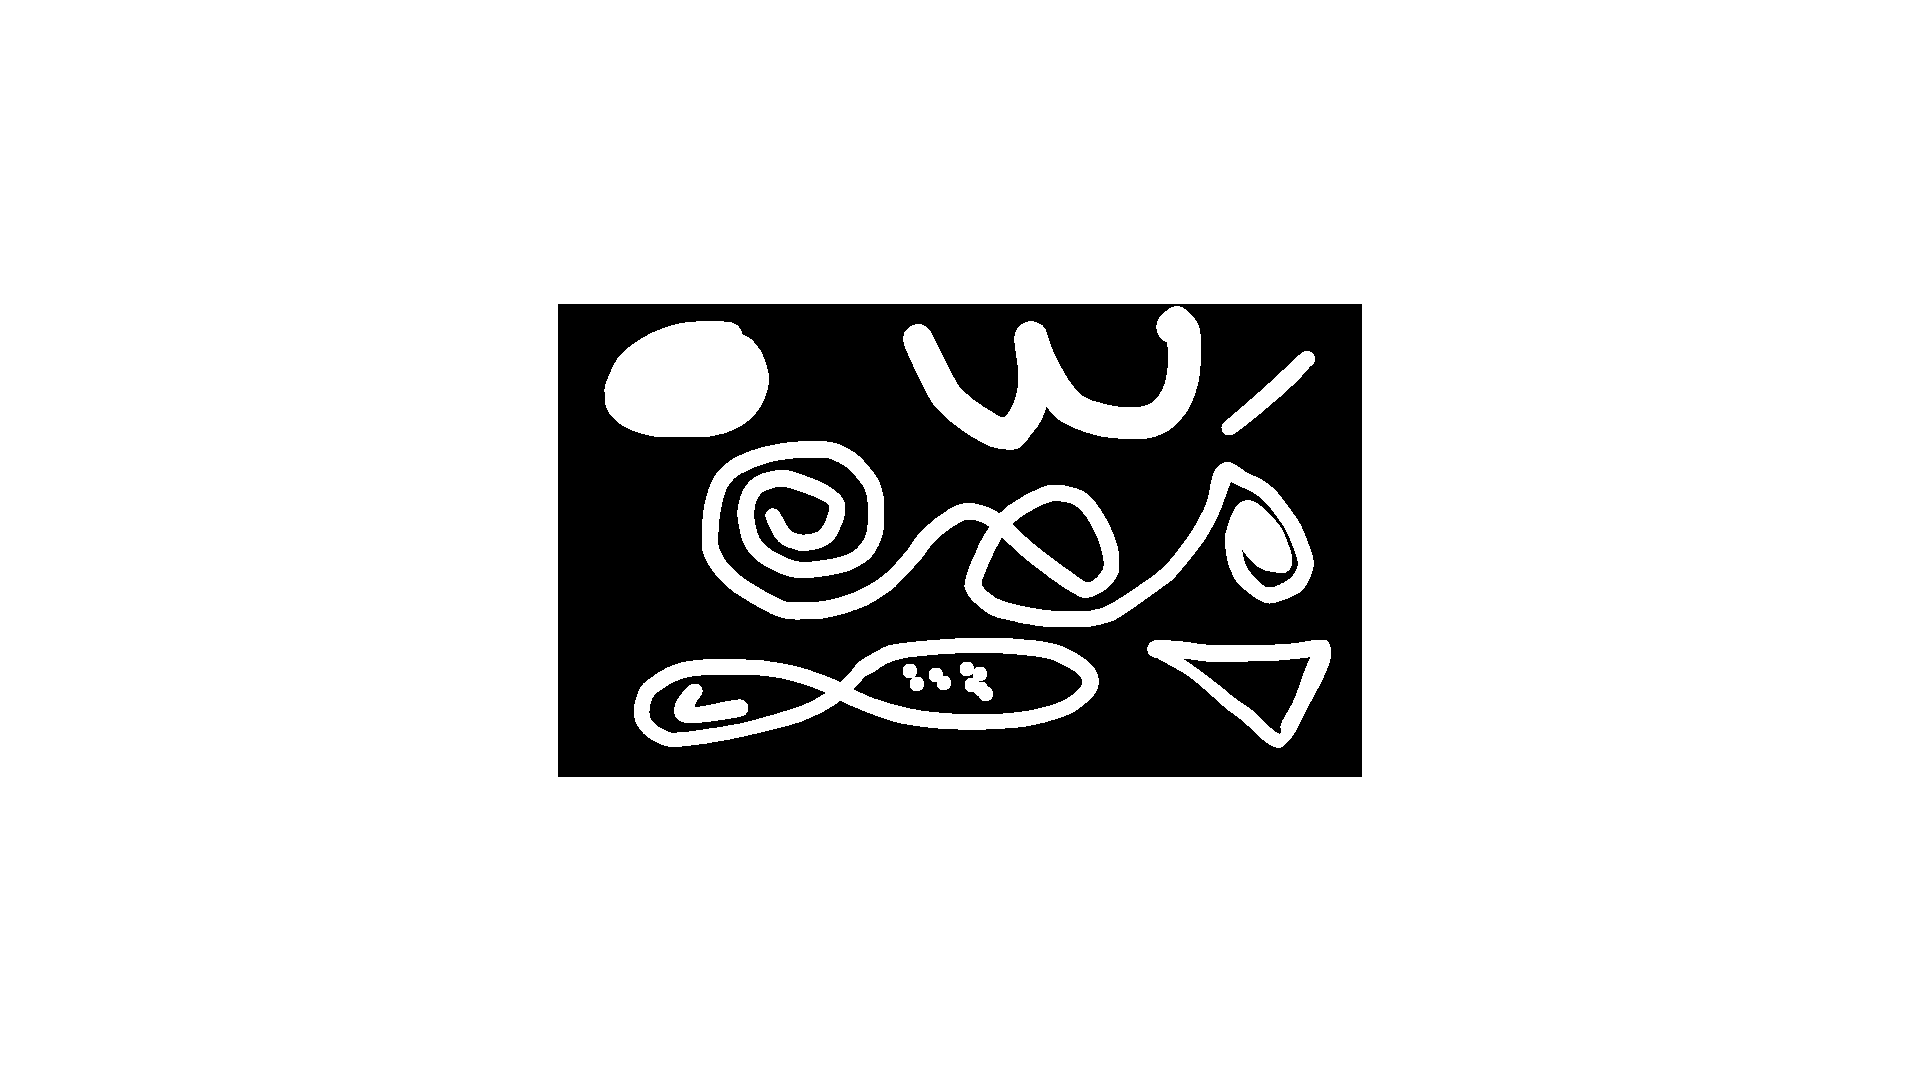

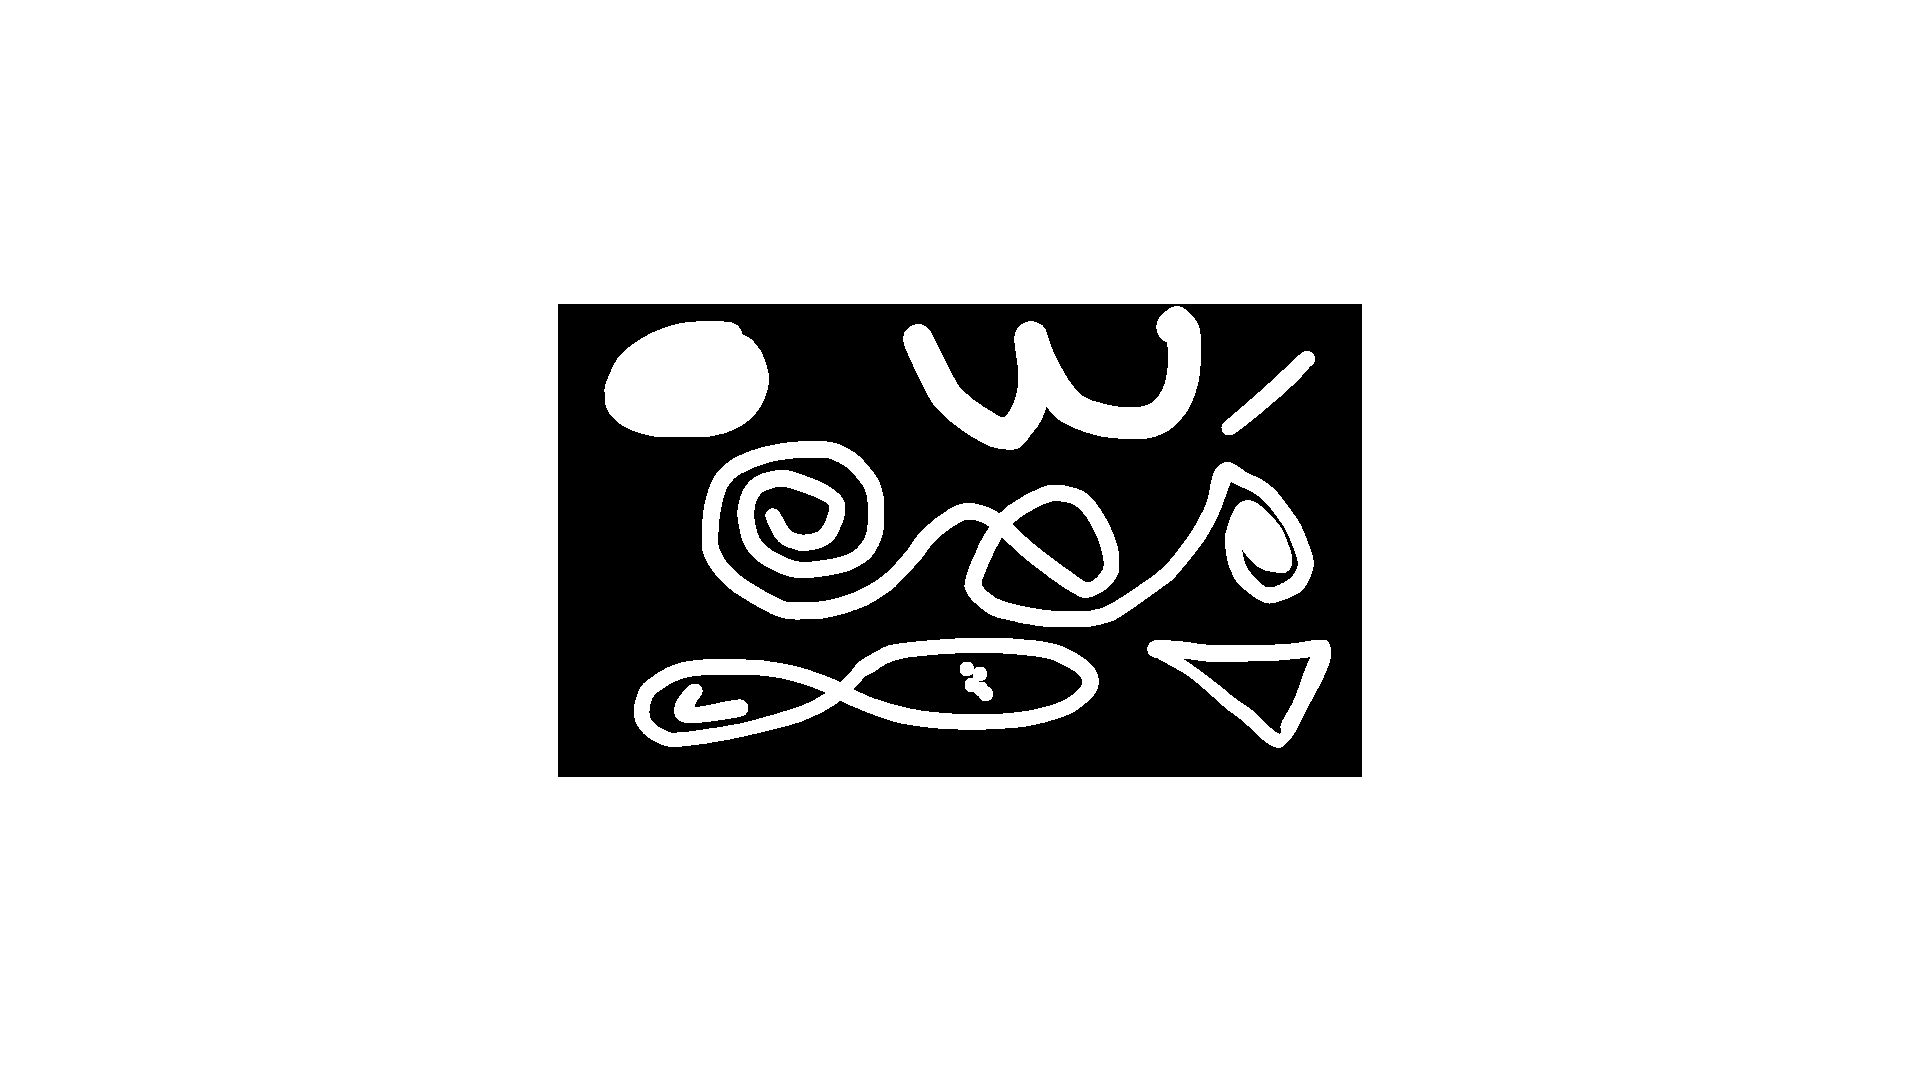

In [3]:
def ccAreaFilter(image, threshold):
    labels, components = ccLabel(image)
    filtered_image = np.zeros_like(image)

    for label, pixels in components.items():
        if len(pixels) >= threshold:
            for x, y in pixels:
                filtered_image[x, y] = image[x, y]

    return filtered_image

# Charger une image en niveaux de gris pour ccLabel
image_gray = cv2.imread('/content/Untitled design.png', cv2.IMREAD_GRAYSCALE)
binary_image = binarize_image(image_gray)
cv2_imshow(binary_image)
filtered_image = ccAreaFilter(binary_image, 500)
cv2_imshow(filtered_image)

# Exercice 3 : Etiquetage en composantes connexes - Mieux

In [28]:
import time
from collections import defaultdict

def ccTwoPassLabel(binary_image):
    # Initialize label matrix and label counter
    rows, cols = binary_image.shape
    label_matrix = np.zeros_like(binary_image, dtype=int)
    current_label = 1
    equivalence = defaultdict(set)

    # First pass: Labeling
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 1:
                # Get labels of top and left neighbors
                neighbors = []
                if i > 0 and label_matrix[i-1, j] != 0:
                    neighbors.append(label_matrix[i-1, j])
                if j > 0 and label_matrix[i, j-1] != 0:
                    neighbors.append(label_matrix[i, j-1])

                if not neighbors:
                    # No labeled neighbors, assign new label
                    label_matrix[i, j] = current_label
                    current_label += 1
                else:
                    # Assign the minimum label among neighbors
                    min_label = min(neighbors)
                    label_matrix[i, j] = min_label
                    # Record equivalence if there are multiple labels
                    for neighbor_label in neighbors:
                        if neighbor_label != min_label:
                            equivalence[min_label].add(neighbor_label)

    # Second pass: Resolve equivalences
    for i in range(rows):
        for j in range(cols):
            if label_matrix[i, j] != 0:
                # Find the root label
                root = label_matrix[i, j]
                while root in equivalence:
                    root = min(equivalence[root])
                label_matrix[i, j] = root

    return label_matrix


def test_performance(random_image):

    start_time = time.time()
    labels1, _ = ccLabel(random_image)
    time_flood_fill = time.time() - start_time

    start_time = time.time()
    labels2 = ccTwoPassLabel(random_image)
    time_two_pass = time.time() - start_time

    print(f"Flood-Fill Method Time: {time_flood_fill:.6f} sec")
    print(f"Two-Pass Method Time: {time_two_pass:.6f} sec")

image_gray = cv2.imread('/content/Untitled design.png', cv2.IMREAD_GRAYSCALE)
binary_image = binarize_image(image_gray)
test_performance(binary_image)

Flood-Fill Method Time: 14.110059 sec
Two-Pass Method Time: 3.943987 sec


# Seuillage par histogramme et méthode d’Otsu

In [5]:
def thresholdOtsu(image):
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 256))
    total_pixels = image.size
    best_threshold = 0
    max_variance = 0

    sum_all = np.dot(histogram, np.arange(256))
    weight_bg = 0
    sum_bg = 0

    for t in range(256):
        weight_bg += histogram[t]
        if weight_bg == 0:
            continue
        weight_fg = total_pixels - weight_bg
        if weight_fg == 0:
            break

        sum_bg += t * histogram[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_all - sum_bg) / weight_fg

        variance_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        if variance_between > max_variance:
            max_variance = variance_between
            best_threshold = t

    return best_threshold

101


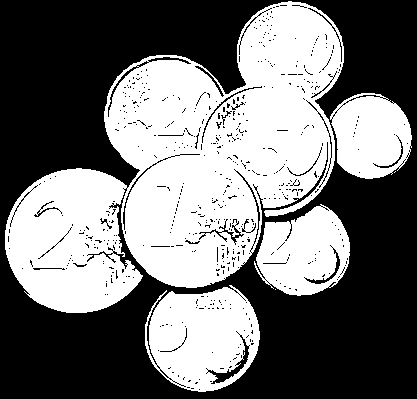

In [6]:
image_gray = cv2.imread('/content/original.png', cv2.IMREAD_GRAYSCALE)
thre = thresholdOtsu(image_gray)
print(thre)
binary_image = binarize_image(image_gray, thre)

cv2_imshow(binary_image)

# Segmentation par croissance de régions

In [12]:
def region_growing(image, seed, threshold):
    """
    Region growing algorithm

    :param image: Input image (2D numpy array)
    :param seed: Seed point (tuple of y, x coordinates)
    :param threshold: Intensity threshold for region growing
    :return: Segmented binary image
    """
    rows, cols = image.shape
    segmented = np.zeros((rows, cols), dtype=np.uint8)
    segmented[seed] = 1
    seed_value = image[seed]

    def _get_neighbors(y, x):
        return [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]

    stack = [seed]
    while stack:
        y, x = stack.pop()
        for ny, nx in _get_neighbors(y, x):
            if 0 <= ny < rows and 0 <= nx < cols:
                if segmented[ny, nx] == 0 and abs(int(image[ny, nx]) - int(seed_value)) <= threshold:
                    segmented[ny, nx] = 1
                    stack.append((ny, nx))

    return segmented

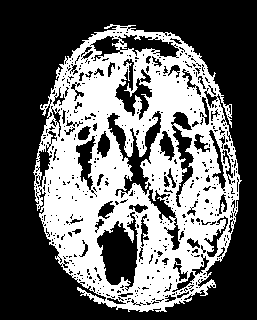

In [23]:
image = cv2.imread('/content/MRI-Brain-Images-abenign-bmalignant-images.jpg', cv2.IMREAD_GRAYSCALE)
seed = (200, 200)  # Example seed point (y, x)
threshold = 35  # higher the resolution, keep higher the thresholding value
result = region_growing(image, seed, threshold)
cv2_imshow(result * 255)

Max Iterations
Iterations : 200138


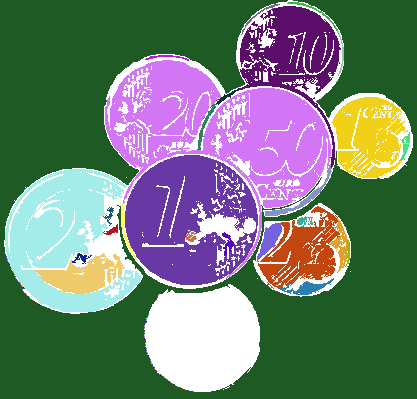

In [8]:
import cv2
import itertools
import numpy as np
import random
import sys
from google.colab.patches import cv2_imshow

# Class for a stack
class Stack():
    def __init__(self):
        self.item = []
        self.obj=[]
    def push(self, value):
        self.item.append(value)

    def pop(self):
        return self.item.pop()

    def size(self):
        return len(self.item)

    def isEmpty(self):
        return self.size() == 0

    def clear(self):
        self.item = []

class regionGrow():

    def __init__(self,im_path,th):
        self.readImage(im_path)
        self.h, self.w,_ =  self.im.shape
        self.passedBy = np.zeros((self.h,self.w), np.double)
        self.currentRegion = 0
        self.iterations=0
        self.SEGS=np.zeros((self.h,self.w,3), dtype='uint8')
        self.stack = Stack()
        self.thresh=float(th)
    def readImage(self, img_path):
        self.im = cv2.imread(img_path,1).astype('int')

    def getNeighbour(self, x0, y0):
        return [
            (x, y)
            for i, j in itertools.product((-1, 0, 1), repeat=2)
            if (i, j) != (0, 0) and self.boundaries(x := x0 + i, y := y0 + j)
        ]

    def create_seeds(self):
        return [
            [self.h/2,self.w/2],
            [self.h/3,self.w/3],[2*self.h/3,self.w/3],[self.h/3-10,self.w/3],
            [self.h/3,2*self.w/3],[2*self.h/3,2*self.w/3],[self.h/3-10,2*self.w/3],
            [self.h/3,self.w-10],[2*self.h/3,self.w-10],[self.h/3-10,self.w-10]
                    ]
    def ApplyRegionGrow(self, cv_display = True):

        randomseeds = self.create_seeds()
        np.random.shuffle(randomseeds)

        for x0 in range (self.h):
            for y0 in range (self.w):

                if self.passedBy[x0,y0] == 0 : #and (np.all(self.im[x0,y0] > 0)) :
                    self.currentRegion += 1
                    self.passedBy[x0,y0] = self.currentRegion
                    self.stack.push((x0,y0))
                    self.prev_region_count= 0

                    while not self.stack.isEmpty():
                        x,y = self.stack.pop()
                        self.BFS(x,y)
                        self.iterations+=1

                    if self.PassedAll():
                        break

                    if self.prev_region_count< 8*8 :
                       x0, y0 = self.reset_region(x0, y0)



        if self.iterations>200000:
            print("Max Iterations")
        print(f"Iterations : {str(self.iterations)}")

        if cv_display:
            [self.color_pixel(i,j) for i, j in itertools.product(range(self.h), range (self.w))]
            self.display()

    def reset_region(self, x0, y0):

        self.passedBy[self.passedBy==self.currentRegion] = 0
        x0=random.randint(x0-4,x0+4)
        y0=random.randint(y0-4,y0+4)
        x0 = np.clip(x0, 0, self.h - 1)
        y0 = np.clip(y0, 0, self.w - 1)
        self.currentRegion-=1
        return x0, y0

    def color_pixel(self, i, j):
        val = self.passedBy[i][j]
        self.SEGS[i][j] = (255, 255, 255) if (val==0) else (val*35, val*90, val*30)

    def display(self):
        cv2_imshow(self.SEGS)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def BFS(self, x0,y0):

        regionNum = self.passedBy[x0,y0]

        elems = [np.mean(self.im[x0, y0])]

        var=self.thresh

        neighbours=self.getNeighbour(x0,y0)

        for x,y in neighbours:
            if self.passedBy[x,y] == 0 and self.distance(x,y,x0,y0) < var:

                if self.PassedAll():
                    break

                self.passedBy[x,y] = regionNum
                self.stack.push((x,y))
                elems.append(np.mean(self.im[x,y]))
                var=np.var(elems)
                self.prev_region_count+=1
            var=max(var,self.thresh)



    def PassedAll(self, max_iteration = 200000):

        return self.iterations > max_iteration or np.all(self.passedBy > 0)


    def boundaries(self, x,y):
        return  0<=x<self.h and 0<=y<self.w

    def distance(self,x,y,x0,y0):

        return np.linalg.norm(self.im[x0, y0] - self.im[x, y])

# Example usage
exemple = regionGrow("/content/original.png", "20")
exemple.ApplyRegionGrow()

# Segmentation par décomposition/fusion (split/merge)

In [24]:
def is_homogeneous(region, threshold):
    """Check if the region is homogeneous based on the intensity threshold."""
    min_val, max_val = np.min(region), np.max(region)
    return (max_val - min_val) <= threshold

def split_and_merge(image, threshold):
    """Segment the image by recursively splitting and merging regions."""

    def recursive_split(region):
        rows, cols = region.shape
        if rows <= 1 or cols <= 1:
            return np.zeros_like(region, dtype=np.uint8)

        if is_homogeneous(region, threshold):
            return np.ones_like(region, dtype=np.uint8)

        # Split the region into four quadrants
        mid_row, mid_col = rows // 2, cols // 2

        # Ensure quadrants are correctly sized
        top_left = region[:mid_row, :mid_col]
        top_right = region[:mid_row, mid_col:]
        bottom_left = region[mid_row:, :mid_col]
        bottom_right = region[mid_row:, mid_col:]

        # Create empty segmented image of the same size
        segmented_quadrants = np.zeros_like(region, dtype=np.uint8)

        # Recursive splitting and assignment to segmented_quadrants
        segmented_quadrants[:mid_row, :mid_col] = recursive_split(top_left)
        segmented_quadrants[:mid_row, mid_col:] = recursive_split(top_right)
        segmented_quadrants[mid_row:, :mid_col] = recursive_split(bottom_left)
        segmented_quadrants[mid_row:, mid_col:] = recursive_split(bottom_right)

        return segmented_quadrants

    def merge_regions(segmented):
        """Merge adjacent regions if they are similar."""
        # Placeholder function for merging adjacent regions if needed
        return segmented

    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the region splitting and merging algorithm
    segmented_image = recursive_split(image)
    segmented_image = merge_regions(segmented_image)

    return segmented_image

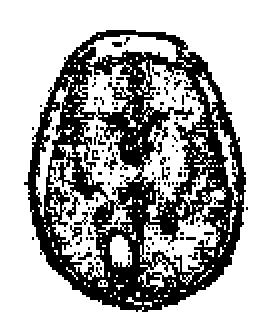

In [25]:
image = cv2.imread('/content/MRI-Brain-Images-abenign-bmalignant-images.jpg', cv2.IMREAD_GRAYSCALE)

# Set the threshold for homogeneity
threshold = 10  # Adjust this value as needed

# Segment the image
result = split_and_merge(image, threshold)

cv2_imshow(result * 255)